In [55]:
import tensorflow as tf
import mediapipe as mp
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import sklearn
import time

In [73]:
mp_hol = mp.solutions.holistic
mp_draw = mp.solutions.drawing_utils
mp_face = mp.solutions.face_mesh 

In [63]:
def mp_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [74]:
def draw_landmarks(image, results):
    mp_draw.draw_landmarks(image, results.face_landmarks, mp_face.FACEMESH_TESSELATION,
                          
                          )
    mp_draw.draw_landmarks(image, results.pose_landmarks, mp_hol.POSE_CONNECTIONS)
    mp_draw.draw_landmarks(image, results.left_hand_landmarks, mp_hol.HAND_CONNECTIONS)
    mp_draw.draw_landmarks(image, results.right_hand_landmarks, mp_hol.HAND_CONNECTIONS)

In [84]:
mp_draw.draw_landmarks??

Signature:
mp_draw.draw_landmarks(
    image: numpy.ndarray,
    landmark_list: mediapipe.framework.formats.landmark_pb2.NormalizedLandmarkList,
    connections: Union[List[Tuple[int, int]], NoneType] = None,
    landmark_drawing_spec: Union[mediapipe.python.solutions.drawing_utils.DrawingSpec, Mapping[int, mediapipe.python.solutions.drawing_utils.DrawingSpec]] = DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=2),
    connection_drawing_spec: Union[mediapipe.python.solutions.drawing_utils.DrawingSpec, Mapping[Tuple[int, int], mediapipe.python.solutions.drawing_utils.DrawingSpec]] = DrawingSpec(color=(224, 224, 224), thickness=2, circle_radius=2),
    is_drawing_landmarks: bool = True,
)
Source:   
def draw_landmarks(
    image: np.ndarray,
    landmark_list: landmark_pb2.NormalizedLandmarkList,
    connections: Optional[List[Tuple[int, int]]] = None,
    landmark_drawing_spec: Union[DrawingSpec,
                                 Mapping[int, DrawingSpec]] = DrawingSpec(
      

In [81]:
cap = cv2.VideoCapture(0)

with mp_hol.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
    
        image, results = mp_detection(frame, holistic)

        draw_landmarks(image, results)
        
        cv2.imshow('OpenCV Feed', image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [75]:
draw_landmarks(frame, results)

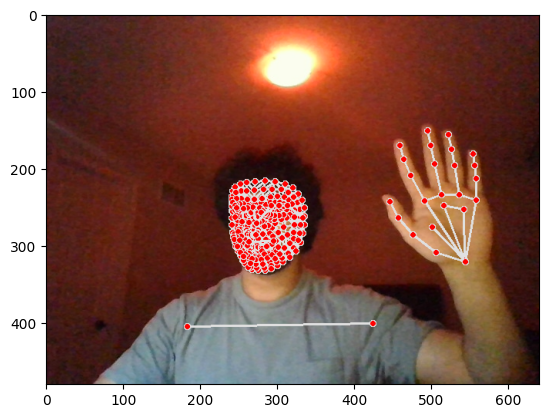

In [78]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))